# Mestrado Prossional de Economia INSPER - Turma MPE16
# Trabalho de conclusão do curso de Finanças Quantitativas (2020.1)


#### Autores: Ciro Aloísio de Paula Duarte, João Italo Zecchin Reis, Robert Aldo Andreotti Filho 


#### O relatório do trabalho está separado em dois arquivos de Jupyter Notebook, onde esta é a primeira:
    Parte 1: Desenvolvimento dos trackers e dos sinais de momentum, value e carry das moedas analisadas contra o dólar americano.
    Parte 2: Criação da estratégia de trading e realização do backtest.

##    
## PARTE 1
##    


## Introdução

O objetivo do trabalho é criarmos uma estratégia de pair trading entre moedas de um mesmo bloco econômico que faça sentido a comparação entre elas duas a duas. 

A proposta deste primeiro jupyter notebook é gerarmos as bases em excel contendo os trackers e os sinais de momentum, value e carry de cada moeda escolhida contra o dólar. Tais dados serão usados como critério de decisão na estratégia do notebook seguinte.

Vale ressaltar que como fonte de dados usamos sempre informações extraídas da Bloomberg.

In [1]:
#import das bibliotecas usadas
import os
import datetime
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
import statsmodels.api as sm
from scipy.stats import norm
%matplotlib inline
from bloomberg import BBG
bbg = BBG()

Período analisado:

In [2]:
start_date ='2009-01-01'
end_date ='2019-12-31'

Este notebook foi desenvolvido para aceitar qualquer uma das moedas abaixo:

    AUD: Australian dollar
    BRL: Brazilian real
    CAD: Cannadian dollar
    CHF: Swiss franc
    CLP: Chilean peso 
    CZK: Czech koruna
    EUR: Euro
    GBP: British pound
    HUF: Hungarian forint
    JPY: Japanese yen
    KRW: South Korean won
    MXN: Mexican peso
    NOK: Norwegian krone
    NZD: New Zealand dollar
    PHP: Philippine peso
    PLN: Złoty
    SEK: Swedish krona
    SGD: Singapore dollar
    TRY: Turkish lira
    TWD: Taiwan dollar
    ZAR: South African rand

In [3]:
#Dicionário usado para relacionar os símbolos das moedas com os códigos de suas taxas de juros na bloomberg
deposit_rates_dict = {'EUR': 'EUDRC', 'JPY': 'JYDRC', 'GBP': 'BPDRC', 'CHF': 'SFDRC', 'CAD': 'CDDRC', 'AUD': 'ADDRC', 
                      'NZD': 'NDDRC', 'NOK': 'NKDRC', 'SEK': 'SKDRC', 'DKK': 'DKDRC', 'CZK': 'CKDRC', 'HUF': 'HFDRC',
                      'ISK': 'IKDRC', 'PLN': 'PZDRC', 'SKK': 'VKDRC', 'TRY': 'TYDRC', 'ZAR': 'SADRC', 'HKD': 'HDDRC',
                      'INR': 'IRDRC', 'IDR': 'IHDRC', 'PHP': 'PPDRC', 'SGD': 'SDDRC', 'KRW': 'KWDRC', 'CNY': 'CCNI3M',
                      'MYR': 'MRDRC', 'TWD': 'NTDRC', 'THB': 'TBDRC', 'ARS': 'APDRC', 'BRL': 'BCDRC', 'CLP': 'CHDRC',
                      'COP': 'CLDRC', 'MXN': 'MPDRC', 'PEN': 'PSDRC', 'USD': 'USDRC'}

###   
#### Definição das moedas usadas na estratégia

Para executar nossa estratégia de trading decidimos separar as moedas em três grupos, cada qual com uma característica econômica para então fazermos o pair trading entre todas as moedas de uma mesma cesta.

Importante destacar que neste Jupyter Notebook todos os sinais e os trackers foram gerados considerando short USD e long moedas abaixo. Dito isto, em vez de negociarmos BRLMXN (long BRL short USD), faremos: long BRLUSD e short MXNUSD, cujo efeito é semelhante desconsiderando custos de corretagem, riscos de liquidez e latência nas execuções simultâneas das ordens, por exemplo.

No projeto separamos três blocos:

    - Moedas de países da Europa (EUR, GBP e SEK); 
    - Moedas de países relevantes em commodities (AUD, CAD, NOK e ZND);
    - Moedas de países emergentes e Latam (BRL e MXN);

In [4]:
#inicialização das listas dos blocos para evitar que em novas execuções do código possa ter lixo na memória
europe = []
cmdty = []
latam = []

#definição dos blocos de moedas em listas
europe = ['EUR', 'GBP', 'SEK']
cmdty = ['AUD', 'CAD', 'NOK', 'NZD']
latam = ['BRL', 'MXN', 'CLP']


#união das moedas em uma lista única
basket = europe + cmdty + latam

In [5]:
#definição do dataframe pair_ccy que será usado ao londo do código
basket_df = pd.DataFrame(basket, columns = ['cross currency'])
pair_ccy = pd.DataFrame(index=basket_df.index, columns = ['cross currency', 'country id', 'deposit rates bbg', 'quote bbg']) 
for i,pair in basket_df.iterrows():
    pair_ccy.iloc[i]  = 0
    pair_ccy['cross currency'].iloc[i] = pair['cross currency'] + 'USD Curncy'
    pair_ccy['country id'].iloc[i] = basket[i]
    pair_ccy['deposit rates bbg'].iloc[i] = deposit_rates_dict[pair_ccy['country id'].iloc[i]] + ' BDSR Curncy'
    inverse_quote = bbg.fetch_contract_parameter(securities=pair_ccy['country id'].iloc[i] + ' Curncy', field='INVERSE_QUOTED')
    pair_ccy['quote bbg'].iloc[i] = pair_ccy['country id'].iloc[i]  + 'USD Curncy' if inverse_quote.iloc[0,0]=='Y' else 'USD' + pair_ccy['country id'].iloc[i]  + ' Curncy'
     
tot_ccy = len(pair_ccy)
pair_ccy

,cross currency,country id,deposit rates bbg,quote bbg
0,EURUSD Curncy,EUR,EUDRC BDSR Curncy,EURUSD Curncy
1,GBPUSD Curncy,GBP,BPDRC BDSR Curncy,GBPUSD Curncy
2,SEKUSD Curncy,SEK,SKDRC BDSR Curncy,USDSEK Curncy
3,AUDUSD Curncy,AUD,ADDRC BDSR Curncy,AUDUSD Curncy
4,CADUSD Curncy,CAD,CDDRC BDSR Curncy,USDCAD Curncy
5,NOKUSD Curncy,NOK,NKDRC BDSR Curncy,USDNOK Curncy
6,NZDUSD Curncy,NZD,NDDRC BDSR Curncy,NZDUSD Curncy
7,BRLUSD Curncy,BRL,BCDRC BDSR Curncy,USDBRL Curncy
8,MXNUSD Curncy,MXN,MPDRC BDSR Curncy,USDMXN Curncy
9,CLPUSD Curncy,CLP,CHDRC BDSR Curncy,USDCLP Curncy


## TRACKERS

Nesta nessão criamos os trackers para todas moedas das nossas cestas considerando short USD

Nota-se a construção de de três tipos de trackers:
- Spot index: considera apenas a variação diária das cotações da moeda como tracker, ou seja, mantidos inalterados os juros das moedas que compõe os pares.
- Total return: além das variações das cotações consideramos as taxas de juros das moedas que estamos comprados para darmos a importância a depreciação que ocorre ao longo do tempo.
- Excess return: total returning considerando o cost of funding da moeda que estamos vendidos, no caso o dólar americano.

Extrações de bases de dados da bloomberg.

In [6]:
#cotações das moedas contra o dólar
ticker_ccys = pair_ccy['cross currency'].tolist()
quote_bbg = bbg.fetch_series(securities=ticker_ccys, fields='PX_LAST', startdate=start_date, enddate=end_date)
quote_bbg = quote_bbg.fillna(method='ffill').dropna()

#deposit rates 3M do dólar, considerado como funding no calculo de excess return
fund_rate_data = bbg.fetch_series(securities='USDRC BDSR Curncy', fields='PX_LAST', startdate=start_date,enddate=end_date)

#deposit rates 3M das moedas da estratégia
ticker_rates = pair_ccy['deposit rates bbg'].values.tolist()
ccy_rates = bbg.fetch_series(securities=ticker_rates, fields='PX_LAST', startdate=start_date, enddate=end_date)

#concatenacao da base dados em um único dataframe
bbg_raw_data_df = pd.concat([quote_bbg, ccy_rates, fund_rate_data],join='outer',axis=1,sort=True)
bbg_raw_data_df = bbg_raw_data_df.fillna(method='ffill').dropna() # drop missing data

No bloco de código abaixo calculamos, para cada um dos pares de moeda,  o spot return, total return e excess return, ainda que para o tracker final consideremos apenas o excess return.

In [7]:
#inicialização dos dataframes
aux_df =  pd.DataFrame(index=pair_ccy.index, columns = ['ccy'])
aux_df['ccy'] = pair_ccy['cross currency'].apply(lambda x : x[:6])
spot_index_df = pd.DataFrame(index=bbg_raw_data_df.index, columns = aux_df['ccy'].values.tolist())
total_return_df =  pd.DataFrame(index=bbg_raw_data_df.index, columns = aux_df['ccy'].values.tolist())
excess_return_df =  pd.DataFrame(index=bbg_raw_data_df.index, columns = aux_df['ccy'].values.tolist())
spot_index_df.iloc[0] = 100
total_return_df.iloc[0] = 100
excess_return_df.iloc[0] = 100

#loop para todas as moedas
for i, pair in pair_ccy.iterrows():
    
    pair_ticker = pair['cross currency']
    for d in range(1, bbg_raw_data_df.shape[0]): 

        #spot return       
        fx_spot_ret = bbg_raw_data_df[pair_ticker].iloc[d]/bbg_raw_data_df[pair_ticker].iloc[d-1]
        spot_index_df[pair_ticker[:6]].iloc[d] = (spot_index_df[pair_ticker[:6]].iloc[d-1])*fx_spot_ret
        
        #interest return diário das moedas
        interest_return = (bbg_raw_data_df.iloc[d-1,i + tot_ccy]/100) / 252 + 1                                                       

        #total return
        total_return = fx_spot_ret*interest_return
        total_return_df[pair_ticker[:6]].iloc[d] = (total_return_df[pair_ticker[:6]].iloc[d-1])*total_return        
        
        #calculo do funding
        funding_cost = (bbg_raw_data_df.iloc[d-1, 2*tot_ccy]/100) / 252 + 1
        
        #excess return
        excess_return = fx_spot_ret*interest_return/funding_cost
        excess_return_df[pair_ticker[:6]].iloc[d] = excess_return_df[pair_ticker[:6]].iloc[d-1]*excess_return

spot_index_df = spot_index_df.fillna(method='ffill').dropna()  
total_return_df = total_return_df.fillna(method='ffill').dropna()  
excess_return_df = excess_return_df.fillna(method='ffill').dropna()                                                                            

###   
Visualização gráfica do excess return das moedas ao longo dotempo. Nota-se que, seguindo o critério de excess return, o real (BRL) foi a moeda que mais se dasvalorizou contra o dólar no período, seguido por perto do EUR. Por outro lado, o peso mexicano (MXN) foi o com maior apreciação.

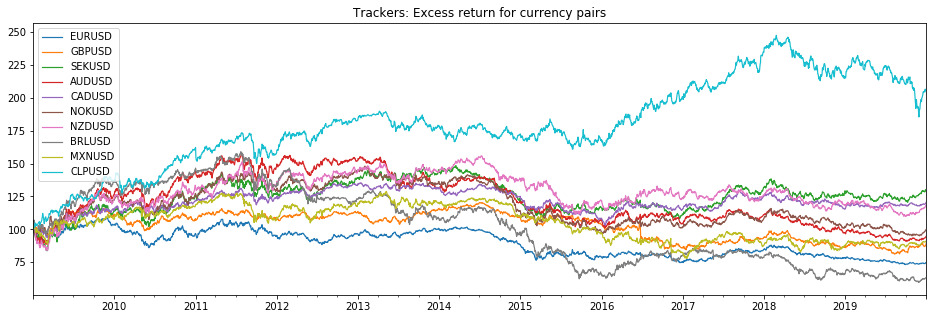

In [8]:
excess_return_df.plot(title='Trackers: Excess return for currency pairs',figsize=(16,5), linewidth=1.2)
plt.show()

##   
## MOMENTUM

Nesta sessão produzimos o primeiro sinal a ser considerado como critério de escolha de compra, venda ou manutenção dos pares de moedas.

Existe uma relação observada de modo empírico que os preços dos ativos continuam a se mover no sentido em que se tem movimento, isto é, um ativo que apresentou valorização em um determinado período recente tem uma tendência a continuar a se valorizar.

Há diferentes formas de cálculo do momentum, para nosso caso consideramos a variação clássica que é dada pela variação percentual em relação à um período antreior de *h* dias. Ademais, ainda ajustamos por uma volatilidade do tipo EWMA com tempo de meia-vida de  60 dias, comumente usada em algorítimos de quantitative trading. Abaixo uma simplificação do calculo do momentum dos nossos ativos:

$$
MOM_{i,t} = \sum_{t=1}^{T} (p_{i,t+p} - p_{i,t})
$$

Onde $p_{i,t+p}$ é o preço do ativo i no período t + p.  

Ressaltamos que há uma questão de reversão a média para ativos como ações, mas moedas não apresentam esse fenômeno.

In [9]:
#Função que retorna um dataframe com as volatilidades do tipo ewma e janela móvel
def get_lagged_vol(ts, h=21, vol_type='ewma', min_vol_window=756, halflife=60):
    lagged_data = ts.astype(float).shift(1)  # note the day lag!!
    lagged_data.index = pd.DatetimeIndex(pd.to_datetime(lagged_data.index))
    if vol_type == 'ewma': # From Moskowitz, Ooi, and Pedersen (2012) and roughly similar to a GARCH(1, 1) model        
        vols = np.sqrt(((np.log(lagged_data).diff(1)**2).ewm(halflife=halflife).mean())*252)
    else:
        if vol_type != 'rolling':
            print('vol_type not recognized, assuming rolling window of %s bdays over %s bday returns' % (min_vol_window,h))
        vols = np.log(lagged_data).diff(h).rolling(window=min_vol_window).std()*np.sqrt(252/h)
    return vols

In [10]:
#Função que retorna um dataframe com o sinal de momentum clássico podendo ser ou não ajustado por sua vol
def momentum_type(ts, h=63, signal_type='classic', vol_adjust=True):
    
    df = ts.astype(float).shift(1) 
    df.index = pd.to_datetime(df.index)

    if signal_type != 'classic':
        print('Momentum signal type was not recognized! assuming default')     
    else:
        df_mom = df.pct_change(h)

        if vol_adjust: 
            if isinstance(vol_adjust,bool):
                vols = get_lagged_vol(ts)                            
            else:
                vols = get_lagged_vol(ts,vol_type=vol_adjust)                                    
            return df_mom/vols
        else:                
            return df_mom

###   
Visualização gráfica do momentum das moedas ao longo do período estudado. Percebe-se que as moedas parecem ter um mesmo padrão de momenum. Vale lembrar que ajustamos as séries por suas volatilidades para podermos realizarmos comparações condizentes.

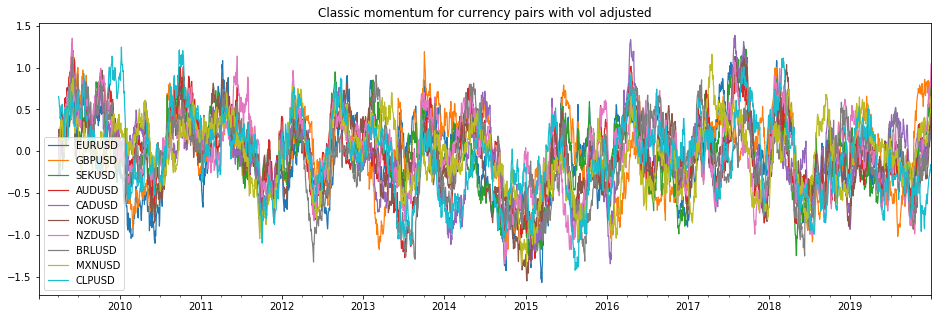

In [11]:
#As default signal_type='classic'and h = 63
momentum = pd.DataFrame()
for i, pair in pair_ccy.iterrows():
    momentum[pair['cross currency'][:6]] = momentum_type(quote_bbg[pair['cross currency']])
momentum.plot(title='Classic momentum for currency pairs with vol adjusted',figsize=(16,5), linewidth=1.2)
plt.show()

## VALUE

Nesta sessão produzimos o segundo sinal a ser considerado como critério de decisão nosso algoritimo.

O value é uma maneira de compararmos pares de moedas que vai além da variação da cotação e das taxas de juros. Aqui, consideramos o poder de compra de bens das moedas.

O cálculo do value foi feito por meio do PPP (Purchasing Power Parity), uma métrica que funciona de forma semelhante ao Índice Big Mac, que compara o preço de um Big Mac em diferentes países. Na teoria, em um mundo sem arbitragens e excluindo custos de transporte, imposto, entre outros, todos os bens devriam ser negociados  a um mesmo preço em uma mesma base monetária. 

De forma objetiva, a idéia é que, no longo prazo, as taxas de câmbio se movam em direção à taxa que igualaria os preços de uma cesta idêntica de bens e serviços em duas áreas monetárias.

No fim, o que queremos é uma forma de calcular as taxas de câmbio real: RER (Real Exchnage Rate) vis à vis uma razão de PPP entre os pasíses.

Na sequência vemos uma representação matemática da RER  de duas moedas ccy1 e ccy2:
#### RER

$$
RER_{ccy1ccy2} = Spot_{ccy1ccy2} \times \frac{PPP_{ccy1}}{PPP_{ccy2}}
$$

Com isso, temos nosso primeiro indicador de value:
#### Value


$$
Value_{ccy1ccy2} = \ln(RER_{ccy1ccy2})
$$


Além do value tradicional representado pelo ln(RER), realizamos o cálculo por outras duas formas diferentes. A primeira, zero mean, captura a variação do value em relação a média dos últimos 252 dias úteis.

#### Zero mean

$$
Zero mean_{ccy1ccy2} = Value_{ccy1ccy2} - média móvel(Value_{ccy1ccy2})
$$

A segunda, z score, considera o zero mean ajustado pela volatilidade do período.

#### Z score

$$
Z score_{ccy1ccy2} = \frac {Zero Mean_{ccy1ccy2}}{std(Zero Mean_{ccy1ccy2})}
$$


Abaixo o dicionário com os códigos das moedas usados para extrairmos os PPPs da bloomberg:

In [13]:
country_dic = {'AUD': 'AS', 'BRL': 'BZ', 'CAD': 'CA', 'CHF': 'SZ', 'CLP': 'CL', 'CZK': 'CZ', 'EUR': 'EUAR',
               'GBP': 'UK', 'HUF': 'HU', 'JPY': 'JN', 'KRW': 'KR', 'MXN': 'MX', 'NOK': 'NO', 'NZD': 'NZ',
               'PHP': 'PH', 'PLN': 'PL', 'SEK': 'SW', 'SGD': 'SG', 'TRY': 'TR', 'TWD': 'TW', 'USD': 'US',
               'ZAR': 'ZA'}

Agora, o bloco de código com o cálculo das métricas de value:

In [15]:
#Definição dos values como dataframes
value =  pd.DataFrame()
zero_mean = pd.DataFrame()
zscore = pd.DataFrame()

#Declaração da moeda base dos PPPs
ccy2 = 'USD'

#Para cada par de moedas, calculamos os tr~es tipos de value
for i, pair in pair_ccy.iterrows():
    
    #moedas da nossa cesta
    ccy1 = basket[i]
    
    #Extração do PPP na bloomberg
    PPP_bbg = bbg.fetch_series(securities=[ccy1 + ' Curncy',ccy2 + ' Curncy',
                                            'PPP ' + country_dic[ccy1.replace(' Curncy','') ] + ' Index',
                                            'PPP ' + country_dic[ccy2.replace(' Curncy','') ] + ' Index'],
                                             fields='PX_LAST', startdate=start_date, enddate=end_date)
    
    PPP_bbg = PPP_bbg.fillna(method='ffill')
    
    #ECálculo do RER
    RER = quote_bbg[pair['cross currency']] * PPP_bbg['PPP ' + country_dic[ccy1.replace(' Curncy','') ] + ' Index']/PPP_bbg['PPP ' + country_dic[ccy2.replace(' Curncy','') ] + ' Index']
    
    #calculo dos três tipos de value
    value[pair_ccy.iloc[i,0][:6]] = np.log(RER).fillna(method='ffill')
    zero_mean[pair_ccy.iloc[i,0][:6]]  = value[pair_ccy.iloc[i,0][:6]]  - value[pair_ccy.iloc[i,0][:6]].rolling(window=252).mean()
    zscore[pair_ccy.iloc[i,0][:6]] = zero_mean[pair_ccy.iloc[i,0][:6]]/value[pair_ccy.iloc[i,0][:6]].rolling(window=252).std()


###   
Visualização gráfica da nossa métrica para value das moedas ao longo do período estudado. 

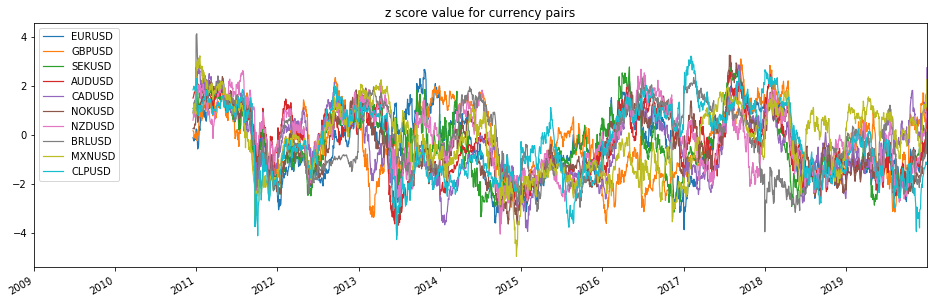

In [16]:
zscore.plot(title='z score value for currency pairs',figsize=(16,5), linewidth=1.2)
plt.show()

## CARRY

#### Deposit rates

$$
Carry_{USDBRL}^{3M} = \frac{1+r_{USD}}{1+r_{BRL}}-1
$$

where $r_{USD}$ is the 3M USD deposit rate and $r_{BRL}$ is the 3M BRL interest rate.


#### Forwards

Recall that by a no-arbitrage argument a currency 3M forward contract should be prices by:

$$
F_{USDBRL}^{3M} = S_{USDBRL} \times \Big(\frac{1+r_{BRL}}{1+r_{USD}}\Big)^{3/12}
$$

where $S_{USDBRL}$ is the spot USDBRL exchange rate. So, an alternative way of defining the 3M annualized carry in USDBRL is:


$$
Carry_{USDBRL}^{3M} = \Big(\frac{S_{USDBRL}}{F_{USDBRL}^{3M}}\Big)^{12/3}-1
$$

#### Volatility adjusted carry

$$
\sigma_{USDBRL}^{-1} \times Carry_{USDBRL}^{3M}
$$

In [17]:
carry =  pd.DataFrame()
fwd_carry = pd.DataFrame()
vol_adj_carry = pd.DataFrame()


for i in range(tot_ccy):
    
    tickers_carry = [deposit_rates_dict[pair_ccy['country id'].iloc[i]] + ' BDSR Curncy', 
                    'USDRC BDSR Curncy', 
                     pair_ccy['cross currency'].iloc[i], 
                     pair_ccy['quote bbg'].iloc[i][:6] + 'V3M BGN Curncy']
    
    rates_bbg = bbg.fetch_series(securities=tickers_carry,fields='PX_LAST', startdate=start_date, enddate=end_date)
    rates_bbg = rates_bbg.fillna(method='ffill')
    rates_bbg['carry'] = (1+rates_bbg.iloc[:,1]/100)/(1+rates_bbg.iloc[:,0]/100)-1
    rates_bbg['fwd'] = rates_bbg.iloc[:,2]*((1+rates_bbg.iloc[:,0]/100)/(1+rates_bbg.iloc[:,1]/100))**(3/12)
    rates_bbg['fwd_carry'] = (rates_bbg.iloc[:,2]/rates_bbg['fwd'])**(12/3) -1
    rates_bbg['vol_adj_carry'] = rates_bbg['fwd_carry']/(rates_bbg.iloc[:,3]/100)

    carry[pair_ccy.iloc[i,0][:6]] = rates_bbg['carry']
    fwd_carry[pair_ccy.iloc[i,0][:6]] = rates_bbg['fwd_carry']
    vol_adj_carry[pair_ccy.iloc[i,0][:6]] = rates_bbg['vol_adj_carry']
    
    

###   
Visualização gráfica da nossa métrica para carry das moedas ao longo do período estudado. 

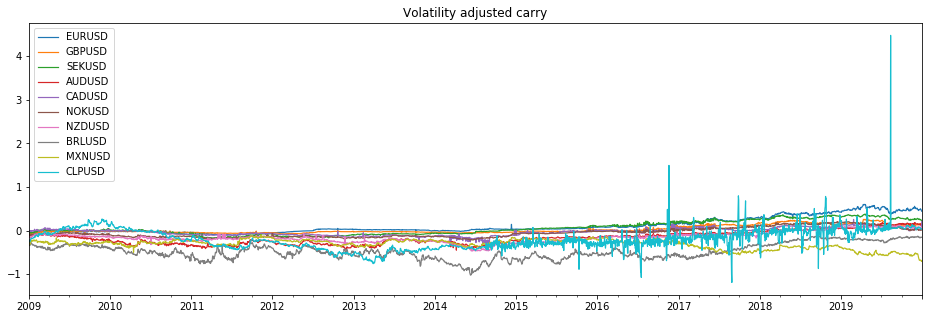

In [18]:
vol_adj_carry.plot(title='Volatility adjusted carry',figsize=(16,5), linewidth=1.2)
plt.show()

### Exportando sinais para excel

In [19]:
excess_return_df.to_excel("trackers.xlsx")
momentum.to_excel("momentum.xlsx")
zero_mean.to_excel("value.xlsx")
fwd_carry.to_excel("carry.xlsx")